# Project 1: Yelp Business Rating Prediction

###### Satjyot Atwal, Hung Quach
###### CSC 180, Section 1

## Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np
from collections.abc import Sequence
import matplotlib.pyplot as plt
import shutil
import os
import json
import csv

from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

save_path = "./Saved_NN/"


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

## Yelp Data Preprocessing

#### Reading JSON review file into dataframe

In [2]:
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

df = pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")

df

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...
...,...,...,...
6685895,RXBFk3tVBxiTf3uOt9KExQ,5.0,b'I have been coming here for years and this p...
6685896,yA6dKNm_zl1ucZCnwW8ZCg,1.0,"b""I think this owner and the owner of Amy's Ba..."
6685897,a192hdM0_UVCYLwPJv1Qwg,5.0,"b'Off the grid Mexican in Vegas. Very tasty, q..."
6685898,kOo4ZY2UQAX4j312mzQ8mA,5.0,"b""We hired Taco Naco to cater our family party..."


#### Reading JSON business file into dataframe

In [3]:
outfile = open("business_names.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','name', 'categories', 'review_count', 'stars'])
with open('business.json', encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['name'].encode('utf-8'), row['categories'], row['review_count'],  row['stars']])

outfile.close()

df_business = pd.read_csv('business_names.tsv', delimiter ="\t", encoding="utf-8")

df_business

,business_id,name,categories,review_count,stars
0,1SWheh84yJXfytovILXOAQ,b'Arizona Biltmore Golf Club',"Golf, Active Life",5,3.0
1,QXAEGFB4oINsVuTFxEYKFQ,b'Emerald Chinese Restaurant',"Specialty Food, Restaurants, Dim Sum, Imported...",128,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,b'Musashi Japanese Restaurant',"Sushi Bars, Restaurants, Japanese",170,4.0
3,xvX2CttrVhyG2z1dFg_0xw,b'Farmers Insurance - Paul Lorenz',"Insurance, Financial Services",3,5.0
4,HhyxOkGAM07SRYtlQ4wMFQ,b'Queen City Plumbing',"Plumbing, Shopping, Local Services, Home Servi...",4,4.0
...,...,...,...,...,...
192604,nqb4kWcOwp8bFxzfvaDpZQ,b'Sanderson Plumbing',"Water Purification Services, Water Heater Inst...",9,5.0
192605,vY2nLU5K20Pee-FdG0br1g,b'Chapters',"Books, Mags, Music & Video, Shopping",3,4.5
192606,MiEyUDKTjeci5TMfxVZPpg,b'Phoenix Pavers',"Home Services, Contractors, Landscaping, Mason...",14,4.5
192607,zNMupayB2jEHVDOji8sxoQ,"b""Beasley's Barber Shop""","Beauty & Spas, Barbers",15,4.5


#### Dropping all records (businesses) that have fewer than 20 records

In [4]:
df_filtered = df_business[df_business['review_count'] >= 20]
df_filtered

,business_id,name,categories,review_count,stars
1,QXAEGFB4oINsVuTFxEYKFQ,b'Emerald Chinese Restaurant',"Specialty Food, Restaurants, Dim Sum, Imported...",128,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,b'Musashi Japanese Restaurant',"Sushi Bars, Restaurants, Japanese",170,4.0
17,PZ-LZzSlhSe9utkQYU8pFg,"b""Carluccio's Tivoli Gardens""","Restaurants, Italian",40,4.0
18,nh_kQ16QAoXWwqZ05MPfBQ,b'Myron Hensel Photography',"Event Planning & Services, Photographers, Prof...",21,5.0
19,zSpQmEBvRe3IhTUlMSA6HQ,b'Totum Life Science',"Trainers, Health & Medical, Active Life, Physi...",23,4.0
...,...,...,...,...,...
192596,KnafX7T6qSAmSrLhd709vA,b'Pho Maisonneuve',"Vietnamese, Soup, Restaurants",25,4.0
192598,vIAEWbTJc657yN8I4z7whQ,b'Starbucks',"Food, Coffee & Tea",138,3.0
192599,ABjONdA5Fw8XBOM65tmW4w,b'Phend Plumbing & Rooter',"Plumbing, Water Heater Installation/Repair, Pr...",47,5.0
192601,jJoPLIhCjkGXy59I4Jl6zw,b'JW Marriott Phoenix Desert Ridge Resort & Spa',"Golf, Hotels, Day Spas, Hotels & Travel, Event...",441,4.0


#### Grouping all reviews by each business.  Creating new dataframe where each line is all the reviews of one business agregated together.

In [5]:
df_review_agg = df.groupby('business_id')['text'].sum()
df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews':df_review_agg.values})
df_all_reviews

,business_id,all_reviews
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...
...,...,...
192601,zzvlwkcNR1CCqOPXwuvz2A,"b""I came here on a Friday night looking for a ..."
192602,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ..."
192603,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...
192604,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...


#### Merging the aggregated, counted, and star dataframes to get the reviews and stars of all the businesses with atleast 20 reviews

In [6]:
df_ready_for_sklearn = pd.merge(df_all_reviews, df_filtered, on='business_id')
df_ready_for_sklearn

,business_id,all_reviews,name,categories,review_count,stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',"Restaurants, Mexican",24,4.0
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...","b""John's Chinese BBQ Restaurant""","Chinese, Restaurants",44,3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',"Breweries, Food",58,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,b'Delmonico Steakhouse',"Cajun/Creole, Seafood, Steakhouses, Restaurants",1613,4.0
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,b'Sunnyside Grill',"Restaurants, Breakfast & Brunch",49,3.5
...,...,...,...,...,...,...
57639,zzsOLFhgUw8gnjLTVVItFA,"b""I'm usually not a big fan of Mexican pastrie...",b'La Purisima Bakery',"Bakeries, Restaurants, Food",105,4.5
57640,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ...",b'Dilly Dally Lounge',"Nightlife, Dive Bars, Bars, Lounges",68,3.5
57641,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...,"b""Carmody's Grille""","Restaurants, American (New)",54,4.0
57642,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...,b'Sizzler',"Buffets, Steakhouses, Salad, Restaurants, Amer...",70,3.0


### Saving the final preprocessed dataframe to a csv file

In [7]:
df_ready_for_sklearn = df_ready_for_sklearn.rename(columns={'stars': 'star_rating'})
df_ready_for_sklearn.to_csv('Business_Star_Rating.csv', index=False)

### Reading the final preprocessed dataframe from the saved csv file

In [8]:
df_ready_for_sklearn = pd.read_csv('Business_Star_Rating.csv', delimiter =",", encoding="utf-8")
df_ready_for_sklearn

,business_id,all_reviews,name,categories,review_count,star_rating
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',"Restaurants, Mexican",24,4.0
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...","b""John's Chinese BBQ Restaurant""","Chinese, Restaurants",44,3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',"Breweries, Food",58,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,b'Delmonico Steakhouse',"Cajun/Creole, Seafood, Steakhouses, Restaurants",1613,4.0
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,b'Sunnyside Grill',"Restaurants, Breakfast & Brunch",49,3.5
...,...,...,...,...,...,...
57639,zzsOLFhgUw8gnjLTVVItFA,"b""I'm usually not a big fan of Mexican pastrie...",b'La Purisima Bakery',"Bakeries, Restaurants, Food",105,4.5
57640,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ...",b'Dilly Dally Lounge',"Nightlife, Dive Bars, Bars, Lounges",68,3.5
57641,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...,"b""Carmody's Grille""","Restaurants, American (New)",54,4.0
57642,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...,b'Sizzler',"Buffets, Steakhouses, Salad, Restaurants, Amer...",70,3.0


## TF-IDF Vectorizer
#### Creating TF-IDF vectorizer that accepts terms that atleast appear twice in one document (all of the bussiness' reviews) and do not appear in more than 95% of the total documents. The max amount of features is 4000. 

In [9]:
# Setting max_df to .95 to filter out stop words. 
vectorizer = sk_text.TfidfVectorizer(min_df=2, max_df=.95, max_features=4000)

# Fitting vectorizer to all the reviews
review_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])
tfidf_data = review_matrix.toarray()
tfidf_data

array([[0.        , 0.        , 0.00864383, ..., 0.01596313, 0.        ,
        0.        ],
       [0.02556777, 0.        , 0.01368874, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01223434, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01674668, ..., 0.        , 0.        ,
        0.296297  ],
       [0.00868179, 0.        , 0.02324073, ..., 0.00536503, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
print(tfidf_data.shape)
vectorizer.get_feature_names()

(57644, 4000)


['00',
 '000',
 '10',
 '100',
 '10pm',
 '11',
 '11am',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '1st',
 '20',
 '200',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2nd',
 '30',
 '300',
 '30am',
 '30pm',
 '32',
 '35',
 '3pm',
 '3rd',
 '40',
 '400',
 '45',
 '4pm',
 '4th',
 '50',
 '500',
 '55',
 '5pm',
 '60',
 '65',
 '6pm',
 '70',
 '75',
 '7pm',
 '80',
 '8pm',
 '90',
 '95',
 '99',
 '9pm',
 'ability',
 'able',
 'above',
 'absolute',
 'absolutely',
 'ac',
 'accept',
 'acceptable',
 'access',
 'accessible',
 'accident',
 'accidentally',
 'accommodate',
 'accommodating',
 'accompanied',
 'according',
 'account',
 'accurate',
 'acknowledge',
 'acknowledged',
 'across',
 'act',
 'acted',
 'action',
 'acts',
 'actual',
 'actually',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'adds',
 'adequate',
 'admission',
 'admit',
 'adorable',
 'adult',
 'adults',
 'advance',
 'advantag

In [11]:
# Convert numpy to df 
Tfdata = pd.DataFrame(tfidf_data, columns=vectorizer.get_feature_names()) 
Tfdata

,00,000,10,100,10pm,11,11am,12,13,14,...,york,young,younger,yourself,yuck,yum,yummy,zero,zoo,zucchini
0,0.000000,0.000000,0.008644,0.000000,0.000000,0.027322,0.0,0.036688,0.017083,0.000000,...,0.000000,0.000000,0.000000,0.012369,0.000000,0.000000,0.000000,0.015963,0.0,0.000000
1,0.025568,0.000000,0.013689,0.000000,0.000000,0.016226,0.0,0.009683,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.012234,0.000000,0.000000,0.000000,0.0,0.011540,0.000000,0.000000,...,0.000000,0.006332,0.010409,0.005835,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.005126,0.001039,0.011639,0.008100,0.001375,0.004066,0.0,0.005374,0.002421,0.004717,...,0.014742,0.001712,0.000938,0.004909,0.000348,0.009937,0.012981,0.001131,0.0,0.000000
4,0.000000,0.000000,0.028452,0.000000,0.000000,0.008993,0.0,0.008051,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009135,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57639,0.000000,0.000000,0.014211,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.007355,0.000000,0.003389,0.000000,0.000000,0.019011,0.000000,0.0,0.000000
57640,0.005998,0.000000,0.008028,0.006171,0.000000,0.006344,0.0,0.000000,0.007933,0.000000,...,0.000000,0.012465,0.000000,0.005743,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
57641,0.000000,0.000000,0.016747,0.000000,0.000000,0.000000,0.0,0.007898,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.296297
57642,0.008682,0.000000,0.023241,0.000000,0.000000,0.000000,0.0,0.004110,0.005741,0.011184,...,0.000000,0.004511,0.000000,0.012471,0.000000,0.005610,0.009327,0.005365,0.0,0.000000


#### Creating a dataframe from the features from the vectorizer and the star rating column

In [12]:
ready_train = pd.concat([df_ready_for_sklearn['star_rating'], Tfdata] , axis=1)
ready_train

,star_rating,00,000,10,100,10pm,11,11am,12,13,...,york,young,younger,yourself,yuck,yum,yummy,zero,zoo,zucchini
0,4.0,0.000000,0.000000,0.008644,0.000000,0.000000,0.027322,0.0,0.036688,0.017083,...,0.000000,0.000000,0.000000,0.012369,0.000000,0.000000,0.000000,0.015963,0.0,0.000000
1,3.0,0.025568,0.000000,0.013689,0.000000,0.000000,0.016226,0.0,0.009683,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,4.0,0.000000,0.000000,0.012234,0.000000,0.000000,0.000000,0.0,0.011540,0.000000,...,0.000000,0.006332,0.010409,0.005835,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,4.0,0.005126,0.001039,0.011639,0.008100,0.001375,0.004066,0.0,0.005374,0.002421,...,0.014742,0.001712,0.000938,0.004909,0.000348,0.009937,0.012981,0.001131,0.0,0.000000
4,3.5,0.000000,0.000000,0.028452,0.000000,0.000000,0.008993,0.0,0.008051,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009135,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57639,4.5,0.000000,0.000000,0.014211,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.007355,0.000000,0.003389,0.000000,0.000000,0.019011,0.000000,0.0,0.000000
57640,3.5,0.005998,0.000000,0.008028,0.006171,0.000000,0.006344,0.0,0.000000,0.007933,...,0.000000,0.012465,0.000000,0.005743,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
57641,4.0,0.000000,0.000000,0.016747,0.000000,0.000000,0.000000,0.0,0.007898,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.296297
57642,3.0,0.008682,0.000000,0.023241,0.000000,0.000000,0.000000,0.0,0.004110,0.005741,...,0.000000,0.004511,0.000000,0.012471,0.000000,0.005610,0.009327,0.005365,0.0,0.000000


#### Saving ready_train dataframe

In [13]:
ready_train.to_csv('ready_train.csv', index=False)

#### Loading ready_train dataframe from saved file

In [14]:
ready_train = pd.read_csv('ready_train.csv', delimiter =",", encoding="utf-8")

## Training and Test Split
#### Dividing data set into training and test sets. 80% of the records are part of the training set and 20% are for testing. The stars column is our target (output).

In [15]:
x, y = to_xy(ready_train,'star_rating')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

review_array_train = x_train
review_array_test = x_test
y_array_train = y_train
y_array_test = y_test

(46115, 4000)
(46115,)
(11529, 4000)
(11529,)


## Neural Network Models

### Neural network with 4 total layers. 2 hidden layers that have 25, 10 neurons and use relu activation functions. Adam optimizer. Input layer has 4000 neurons since the Vectorizer has 4000 features.

In [17]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_relu_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_model = Sequential()

    relu_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='relu'))
    relu_model.add(Dense(10, activation='relu'))
    relu_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    relu_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    relu_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 0.6315 - val_loss: 0.1189
Epoch 2/1000
46115/46115 - 6s - loss: 0.0976 - val_loss: 0.0960
Epoch 3/1000
46115/46115 - 6s - loss: 0.0836 - val_loss: 0.0937
Epoch 4/1000
46115/46115 - 6s - loss: 0.0790 - val_loss: 0.0869
Epoch 5/1000
46115/46115 - 6s - loss: 0.0763 - val_loss: 0.0867
Epoch 6/1000
46115/46115 - 6s - loss: 0.0747 - val_loss: 0.0879
Epoch 7/1000
46115/46115 - 6s - loss: 0.0732 - val_loss: 0.0859
Epoch 8/1000
46115/46115 - 6s - loss: 0.0718 - val_loss: 0.0847
Epoch 9/1000
46115/46115 - 6s - loss: 0.0708 - val_loss: 0.0839
Epoch 10/1000
46115/46115 - 6s - loss: 0.0701 - val_loss: 0.0915
Epoch 11/1000
46115/46115 - 6s - loss: 0.0670 - val_loss: 0.0800
Epoch 12/1000
46115/46115 - 6s - loss: 0.0616 - val_loss: 0.0756
Epoch 13/1000
46115/46115 - 6s - loss: 0.0574 - val_loss: 0.0748
Epoch 14/1000
46115/46115 - 6s - loss: 0.0545 - val_loss: 0.0719
Epoch 15/1000
46115/46115 - 6s - loss: 0

### Neural network with 4 total layers. 2 hidden layers that have 25, 10 neurons and use sigmoid activation functions. Adam optimizer.

In [18]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_sigmoid_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    sigmoid_model = Sequential()

    sigmoid_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='sigmoid'))
    sigmoid_model.add(Dense(10, activation='sigmoid'))
    sigmoid_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    sigmoid_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    sigmoid_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
              callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 7s - loss: 1.4981 - val_loss: 0.6112
Epoch 2/1000
46115/46115 - 6s - loss: 0.3427 - val_loss: 0.1144
Epoch 3/1000
46115/46115 - 6s - loss: 0.0879 - val_loss: 0.0779
Epoch 4/1000
46115/46115 - 6s - loss: 0.0691 - val_loss: 0.0703
Epoch 5/1000
46115/46115 - 6s - loss: 0.0632 - val_loss: 0.0675
Epoch 6/1000
46115/46115 - 6s - loss: 0.0601 - val_loss: 0.0664
Epoch 7/1000
46115/46115 - 6s - loss: 0.0579 - val_loss: 0.0689
Epoch 8/1000
46115/46115 - 6s - loss: 0.0562 - val_loss: 0.0660
Epoch 9/1000
46115/46115 - 6s - loss: 0.0548 - val_loss: 0.0644
Epoch 10/1000
46115/46115 - 6s - loss: 0.0537 - val_loss: 0.0663
Epoch 11/1000
46115/46115 - 6s - loss: 0.0528 - val_loss: 0.0638
Epoch 12/1000
46115/46115 - 6s - loss: 0.0519 - val_loss: 0.0637
Epoch 13/1000
46115/46115 - 6s - loss: 0.0513 - val_loss: 0.0639
Epoch 14/1000
46115/46115 - 6s - loss: 0.0507 - val_loss: 0.0637
Epoch 00014: early stopping

Run:  2
Tra

### Neural network with 4 total layers. 2 hidden layers that have 25, 10 neurons and use tanh activation functions. Adam optimizer.

In [19]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_tanh_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    tanh_model = Sequential()

    tanh_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='tanh'))
    tanh_model.add(Dense(10, activation='tanh'))
    tanh_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    tanh_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    tanh_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
              callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 7s - loss: 0.2871 - val_loss: 0.0786
Epoch 2/1000
46115/46115 - 6s - loss: 0.0707 - val_loss: 0.0718
Epoch 3/1000
46115/46115 - 6s - loss: 0.0638 - val_loss: 0.0682
Epoch 4/1000
46115/46115 - 6s - loss: 0.0594 - val_loss: 0.0667
Epoch 5/1000
46115/46115 - 10s - loss: 0.0564 - val_loss: 0.0655
Epoch 6/1000
46115/46115 - 6s - loss: 0.0543 - val_loss: 0.0661
Epoch 7/1000
46115/46115 - 6s - loss: 0.0525 - val_loss: 0.0670
Epoch 8/1000
46115/46115 - 6s - loss: 0.0510 - val_loss: 0.0651
Epoch 9/1000
46115/46115 - 6s - loss: 0.0495 - val_loss: 0.0656
Epoch 10/1000
46115/46115 - 6s - loss: 0.0483 - val_loss: 0.0676
Epoch 11/1000
46115/46115 - 8s - loss: 0.0470 - val_loss: 0.0682
Epoch 00011: early stopping

Run:  2
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 10s - loss: 0.3420 - val_loss: 0.0783
Epoch 2/1000
46115/46115 - 10s - loss: 0.0697 - val_loss: 0.0704
Epoch 3/1000
4611

### Neural network with 6 total layers. 4 hidden layers that have 25, 50, 50, 25 neurons and use relu activation functions. Adam optimizer.

In [20]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_bigger_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    bigger_model = Sequential()

    bigger_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='relu'))
    bigger_model.add(Dense(50, activation='relu'))
    bigger_model.add(Dense(50, activation='relu'))
    bigger_model.add(Dense(25, activation='relu'))
    bigger_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    bigger_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    bigger_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 0.3560 - val_loss: 0.0809
Epoch 2/1000
46115/46115 - 7s - loss: 0.0690 - val_loss: 0.0789
Epoch 3/1000
46115/46115 - 7s - loss: 0.0609 - val_loss: 0.0752
Epoch 4/1000
46115/46115 - 7s - loss: 0.0560 - val_loss: 0.0689
Epoch 5/1000
46115/46115 - 7s - loss: 0.0523 - val_loss: 0.0779
Epoch 6/1000
46115/46115 - 7s - loss: 0.0483 - val_loss: 0.0725
Epoch 7/1000
46115/46115 - 7s - loss: 0.0449 - val_loss: 0.0740
Epoch 00007: early stopping

Run:  2
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 0.3391 - val_loss: 0.0862
Epoch 2/1000
46115/46115 - 7s - loss: 0.0743 - val_loss: 0.0769
Epoch 3/1000
46115/46115 - 7s - loss: 0.0632 - val_loss: 0.0715
Epoch 4/1000
46115/46115 - 7s - loss: 0.0560 - val_loss: 0.0740
Epoch 5/1000
46115/46115 - 8s - loss: 0.0519 - val_loss: 0.0692
Epoch 6/1000
46115/46115 - 8s - loss: 0.0490 - val_loss: 0.0694
Epoch 7/1000
46115/461

### Neural network with 6 total layers. 2 hidden layers that have 25, 10 neurons and use relu activation functions. SGD optimizer.

In [21]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_sgd_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    sgd_model = Sequential()

    sgd_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='relu'))
    sgd_model.add(Dense(10, activation='relu'))
    sgd_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    sgd_model.compile(loss='mean_squared_error', optimizer='sgd')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    sgd_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 6s - loss: 0.4720 - val_loss: 0.2834
Epoch 2/1000
46115/46115 - 6s - loss: 0.1283 - val_loss: 0.1337
Epoch 3/1000
46115/46115 - 6s - loss: 0.1041 - val_loss: 0.1010
Epoch 4/1000
46115/46115 - 6s - loss: 0.0938 - val_loss: 0.0956
Epoch 5/1000
46115/46115 - 6s - loss: 0.0879 - val_loss: 0.1127
Epoch 6/1000
46115/46115 - 6s - loss: 0.0828 - val_loss: 0.1446
Epoch 7/1000
46115/46115 - 6s - loss: 0.0789 - val_loss: 0.0823
Epoch 8/1000
46115/46115 - 8s - loss: 0.0755 - val_loss: 0.0915
Epoch 9/1000
46115/46115 - 6s - loss: 0.0719 - val_loss: 0.1255
Epoch 10/1000
46115/46115 - 5s - loss: 0.0695 - val_loss: 0.0916
Epoch 00010: early stopping

Run:  2
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 6s - loss: 0.4003 - val_loss: 0.1610
Epoch 2/1000
46115/46115 - 6s - loss: 0.1241 - val_loss: 0.1731
Epoch 3/1000
46115/46115 - 5s - loss: 0.1051 - val_loss: 0.1168
Epoch 4/1000
46115/46

### Neural network with 6 total layers. 4 hidden layers that have 5, 10, 10, 5 neurons and use sigmoid activation functions. Adam optimizer.

In [22]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_mix_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    mix_model = Sequential()

    mix_model.add(Dense(5, input_dim=review_array_train.shape[1], activation='sigmoid'))
    mix_model.add(Dense(10, activation='sigmoid'))
    mix_model.add(Dense(10, activation='sigmoid'))
    mix_model.add(Dense(5, activation='sigmoid'))
    mix_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    mix_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    mix_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 1.9095 - val_loss: 0.6200
Epoch 2/1000
46115/46115 - 7s - loss: 0.6329 - val_loss: 0.6188
Epoch 3/1000
46115/46115 - 7s - loss: 0.6164 - val_loss: 0.4233
Epoch 4/1000
46115/46115 - 8s - loss: 0.1448 - val_loss: 0.0826
Epoch 5/1000
46115/46115 - 7s - loss: 0.0722 - val_loss: 0.0710
Epoch 6/1000
46115/46115 - 7s - loss: 0.0642 - val_loss: 0.0672
Epoch 7/1000
46115/46115 - 8s - loss: 0.0605 - val_loss: 0.0658
Epoch 8/1000
46115/46115 - 7s - loss: 0.0581 - val_loss: 0.0648
Epoch 9/1000
46115/46115 - 7s - loss: 0.0564 - val_loss: 0.0644
Epoch 10/1000
46115/46115 - 7s - loss: 0.0549 - val_loss: 0.0646
Epoch 11/1000
46115/46115 - 8s - loss: 0.0539 - val_loss: 0.0637
Epoch 12/1000
46115/46115 - 8s - loss: 0.0528 - val_loss: 0.0644
Epoch 13/1000
46115/46115 - 8s - loss: 0.0520 - val_loss: 0.0637
Epoch 14/1000
46115/46115 - 8s - loss: 0.0513 - val_loss: 0.0650
Epoch 00014: early stopping

Run:  2
Tra

## Load neural networks from each saved hdf5 file

In [23]:
saved_relu_model = load_model(os.path.join(save_path, "best_weights_relu_model.hdf5"))

saved_sigmoid_model = load_model(os.path.join(save_path, "best_weights_sigmoid_model.hdf5"))

saved_tanh_model = load_model(os.path.join(save_path, "best_weights_tanh_model.hdf5"))

saved_bigger_model = load_model(os.path.join(save_path, "best_weights_bigger_model.hdf5"))

saved_sgd_model = load_model(os.path.join(save_path, "best_weights_sgd_model.hdf5"))

saved_mix_model = load_model(os.path.join(save_path, "best_weights_mix_model.hdf5"))

## Model Evaluations and Predictions

#### RMSE scores of each model to determine best model

In [24]:
# Relu Model Prediction and MSE
relu_model_pred = saved_relu_model.predict(review_array_test)
relu_model_rmse = np.sqrt(metrics.mean_squared_error(relu_model_pred, y_array_test))
print(f'Relu Model RMSE: {relu_model_rmse}')

# Sigmoid Model Prediction and MSE
sigmoid_model_pred = saved_sigmoid_model.predict(review_array_test)
sigmoid_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_model_pred, y_array_test))
print(f'Sigmoid Model RMSE: {sigmoid_model_rmse}')

# Tanh Model Prediction and MSE
tanh_model_pred = saved_tanh_model.predict(review_array_test)
tanh_model_rmse = np.sqrt(metrics.mean_squared_error(tanh_model_pred, y_array_test))
print(f'Tanh Model RMSE: {tanh_model_rmse}')

# Bigger Model Prediction and MSE
bigger_model_pred = saved_bigger_model.predict(review_array_test)
bigger_model_rmse = np.sqrt(metrics.mean_squared_error(bigger_model_pred, y_array_test))
print(f'Bigger Model RMSE: {bigger_model_rmse}')

# SGD Model Prediction and MSE
sgd_model_pred = saved_sgd_model.predict(review_array_test)
sgd_model_rmse = np.sqrt(metrics.mean_squared_error(sgd_model_pred, y_array_test))
print(f'SGD Model RMSE: {sgd_model_rmse}')

# Mix Model Prediction and MSE
mix_model_pred = saved_mix_model.predict(review_array_test)
mix_model_rmse = np.sqrt(metrics.mean_squared_error(mix_model_pred, y_array_test))
print(f'Mix Model RMSE: {mix_model_rmse}')

# Best Model from the above
best_model_rmse = min([relu_model_rmse, sigmoid_model_rmse, tanh_model_rmse, bigger_model_rmse, sgd_model_rmse, mix_model_rmse])
print('\nBest Model RMSE:', best_model_rmse)

Relu Model RMSE: 0.2673337757587433
Sigmoid Model RMSE: 0.2523198425769806
Tanh Model RMSE: 0.2539219260215759
Bigger Model RMSE: 0.26246607303619385
SGD Model RMSE: 0.28652718663215637
Mix Model RMSE: 0.25247976183891296

Best Model RMSE: 0.25231984


### Prediction using best model

In [53]:
print(len(sigmoid_model_pred))
sigmoid_model_pred

11529


array([[4.2274156],
       [2.69336  ],
       [3.501618 ],
       ...,
       [4.0224442],
       [3.593306 ],
       [3.9581473]], dtype=float32)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    df_ready_for_sklearn[['business_id', 'name', 'categories']], df_ready_for_sklearn['star_rating'], test_size=0.2, random_state=11)


best_pred_df = pd.DataFrame(sigmoid_model_pred, columns = ['Prediction'])
x_test_df = pd.DataFrame(x_test).sort_index().reset_index()
y_test_true = y_test.reset_index()

result = pd.concat([x_test_df, y_test_true, best_pred_df], axis=1)
result.drop(['business_id', 'index'], axis=1, inplace=True)


# 5 arbitrary businesses from test dataset true stars and predicted stars
df_comparison = pd.DataFrame(result.loc[[1, 3, 6, 8, 9]])
df_comparison

,name,categories,star_rating,Prediction
1,"b""Lucky's Pet Grooming & Boutique""","Pet Services, Pets, Pet Stores, Pet Groomers",3.0,2.693360
3,b'The Fry',"Bars, Korean, Food, Southern, Restaurants, Nig...",4.5,4.137036
6,b'Red Ginseng Narita Sushi & BBQ',"Korean, Restaurants, Sushi Bars",3.5,3.453538
8,b'Yum Yum BBQ Chicken',"Barbeque, Restaurants, Korean",4.0,4.006008
9,b'Scottsdale Air Heating & Cooling',"Heating & Air Conditioning/HVAC, Home Services",3.0,2.702253


## Model Visuals

### Lift chart of best model

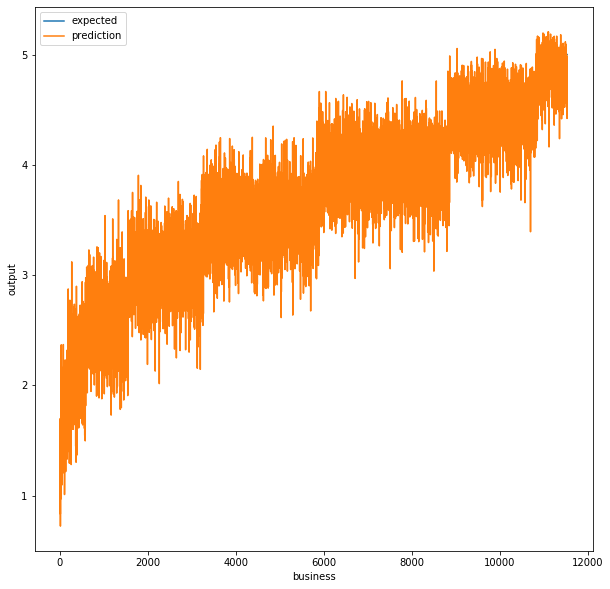

In [55]:
plt.rcParams['figure.figsize'] = [10, 10]

def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.xlabel('business')
    plt.legend()
    plt.show()

chart_regression(sigmoid_model_pred.flatten(), y_array_test, sort=True)

#### Bar plot of RMSE values of the 6 models

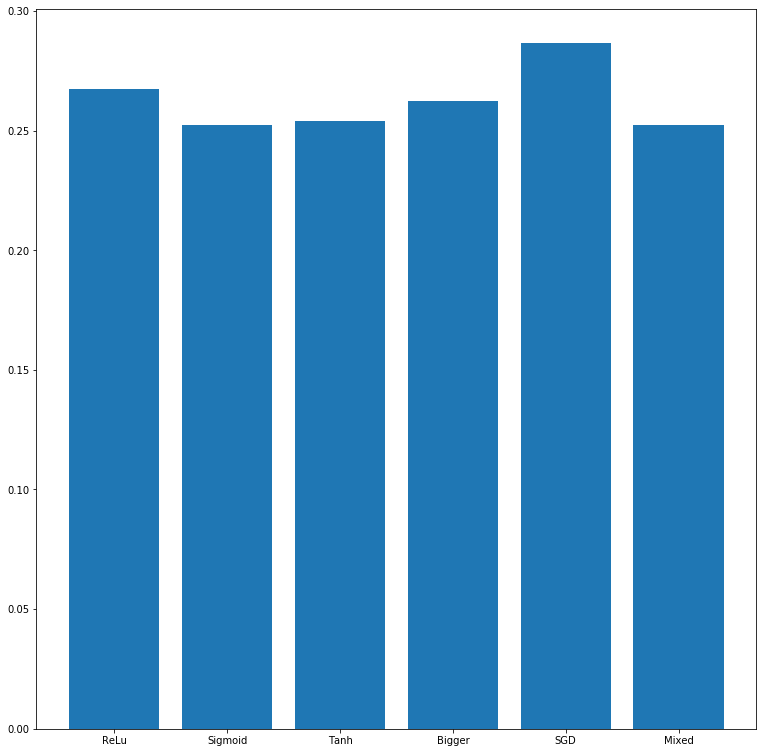

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rmses = [relu_model_rmse, sigmoid_model_rmse, tanh_model_rmse, bigger_model_rmse, sgd_model_rmse, mix_model_rmse]
ax.bar(['ReLu', 'Sigmoid', 'Tanh', 'Bigger', 'SGD', 'Mixed'], rmses)
plt.show()

## Extra
#### Building model that takes review_count into account. Neural network with 6 total layers. 4 hidden layers that have 25, 10, 50, 15 neurons and use tanh activation functions. Adam optimizer. 

In [49]:
ready_train_count = pd.concat([df_ready_for_sklearn[['review_count', 'star_rating']], Tfdata] , axis=1)
ready_train_count

,review_count,star_rating,00,000,10,100,10pm,11,11am,12,...,york,young,younger,yourself,yuck,yum,yummy,zero,zoo,zucchini
0,24,4.0,0.000000,0.000000,0.008644,0.000000,0.000000,0.027322,0.0,0.036688,...,0.000000,0.000000,0.000000,0.012369,0.000000,0.000000,0.000000,0.015963,0.0,0.000000
1,44,3.0,0.025568,0.000000,0.013689,0.000000,0.000000,0.016226,0.0,0.009683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,58,4.0,0.000000,0.000000,0.012234,0.000000,0.000000,0.000000,0.0,0.011540,...,0.000000,0.006332,0.010409,0.005835,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,1613,4.0,0.005126,0.001039,0.011639,0.008100,0.001375,0.004066,0.0,0.005374,...,0.014742,0.001712,0.000938,0.004909,0.000348,0.009937,0.012981,0.001131,0.0,0.000000
4,49,3.5,0.000000,0.000000,0.028452,0.000000,0.000000,0.008993,0.0,0.008051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009135,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57639,105,4.5,0.000000,0.000000,0.014211,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.007355,0.000000,0.003389,0.000000,0.000000,0.019011,0.000000,0.0,0.000000
57640,68,3.5,0.005998,0.000000,0.008028,0.006171,0.000000,0.006344,0.0,0.000000,...,0.000000,0.012465,0.000000,0.005743,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
57641,54,4.0,0.000000,0.000000,0.016747,0.000000,0.000000,0.000000,0.0,0.007898,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.296297
57642,70,3.0,0.008682,0.000000,0.023241,0.000000,0.000000,0.000000,0.0,0.004110,...,0.000000,0.004511,0.000000,0.012471,0.000000,0.005610,0.009327,0.005365,0.0,0.000000


In [56]:
x, y = to_xy(ready_train_count,'star_rating')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

review_array_train = x_train
review_array_test = x_test
y_array_train = y_train
y_array_test = y_test

(46115, 4001)
(46115,)
(11529, 4001)
(11529,)


In [57]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "best_weights_extra_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum
for i in range(3):
    print('\nRun: ', i + 1)

    extra_model = Sequential()

    extra_model.add(Dense(25, input_dim=review_array_train.shape[1], activation='tanh'))
    extra_model.add(Dense(10, activation='tanh'))
    extra_model.add(Dense(50, activation='tanh'))
    extra_model.add(Dense(15, activation='tanh'))
    extra_model.add(Dense(1))

    # Use MSE loss since it is a regression problem
    extra_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

    extra_model.fit(review_array_train, y_array_train, validation_data=(review_array_test, y_array_test), 
                    callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 0.2199 - val_loss: 0.0944
Epoch 2/1000
46115/46115 - 7s - loss: 0.0784 - val_loss: 0.0751
Epoch 3/1000
46115/46115 - 7s - loss: 0.0708 - val_loss: 0.0818
Epoch 4/1000
46115/46115 - 7s - loss: 0.0678 - val_loss: 0.0952
Epoch 00004: early stopping

Run:  2
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 8s - loss: 0.2592 - val_loss: 0.1068
Epoch 2/1000
46115/46115 - 7s - loss: 0.0794 - val_loss: 0.0736
Epoch 3/1000
46115/46115 - 7s - loss: 0.0711 - val_loss: 0.0820
Epoch 4/1000
46115/46115 - 7s - loss: 0.0700 - val_loss: 0.0727
Epoch 00004: early stopping

Run:  3
Train on 46115 samples, validate on 11529 samples
Epoch 1/1000
46115/46115 - 7s - loss: 0.2125 - val_loss: 0.1238
Epoch 2/1000
46115/46115 - 7s - loss: 0.0840 - val_loss: 0.0747
Epoch 3/1000
46115/46115 - 7s - loss: 0.0727 - val_loss: 0.0745
Epoch 4/1000
46115/46115 - 7s - loss: 0.0692 - val_loss: 0.1004

In [58]:
saved_extra_model = load_model(os.path.join(save_path, "best_weights_extra_model.hdf5"))

# Extra Model Prediction and MSE
extra_model_pred = saved_extra_model.predict(review_array_test)
extra_model_rmse = np.sqrt(metrics.mean_squared_error(extra_model_pred, y_array_test))
print(f'Extra Model RMSE: {extra_model_rmse}')

Extra Model RMSE: 0.269631952047348
